In [1]:
import jax
import jaxlib
from jax import grad, jit, vmap
import jax.numpy as np
import jax.random as random
from jax import devices, device_put
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [2]:
import os
os.chdir('../scripts')
import compute_pmass as pm
import compute_iter_metrics as cim
import large_mnl as lmnl

In [3]:
import pandas as pd
from functools import partial
from tqdm import tqdm

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
sample_rates = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]

# Load data

In [6]:
alts_df = pd.read_csv('../data/chts_alts_df.csv', index_col='block_id')
# alts_df = alts_df.sample(20000, replace=False)

In [7]:
store = pd.HDFStore('/home/mgardner/PILATES/pilates/urbansim/data/custom_mpo_06197001_model_data.h5')
hh = store['households']
p = store['persons']
store.close()

In [8]:
p = pd.merge(p, hh, left_on='household_id', right_index=True)

In [135]:
p.block_id.nunique() * alts_df.shape[0]

7285916500

In [134]:
p.shape

(6802651, 45)

In [9]:
alts_df.shape

(106910, 18)

# Format data

In [10]:
num_choosers = int(np.floor((750/200) * len(alts_df)))
print(num_choosers)

400912


In [11]:
num_choosers = 400000

In [12]:
choosers = p[['cars']].sample(num_choosers).values

In [13]:
alts_df[['pct_retail', 'total_jobs', 'persons', 'dist_to_nearest_cbd']] = np.log1p(alts_df[['pct_retail', 'total_jobs', 'persons', 'dist_to_nearest_cbd']].values)
alts = alts_df[['pct_retail', 'total_jobs', 'persons', 'jobs_per_res_unit', 'dist_to_nearest_cbd']].values

# Jax settings

In [16]:
coeffs = np.array([
    2.2708005690814117,
     0.6119614583221185,
     0.037655816769314676,
     -9.098902472454982e-05,
     0.1164899750612353])
key = random.PRNGKey(0)
num_iters = 10
keys = random.split(key, num_choosers)
key_dim = key.shape[0]
n_chooser_batches = 800
choosers_per_batch = int(num_choosers / n_chooser_batches)

In [17]:
choosers = choosers.reshape((n_chooser_batches, choosers_per_batch))
keys = keys.reshape((n_chooser_batches, choosers_per_batch, key_dim))
partial_interaction = partial(
    lmnl.interaction_probs_all_disc,
    alts,
    coeffs,
    1)

# Simulate

In [18]:
# store results on cpu to preserve space on GPU for computation
cpu = devices("cpu")[0]
results = device_put(np.zeros((10, alts.shape[0])), device=cpu)

In [19]:
for i in tqdm(range(n_chooser_batches), total=n_chooser_batches):
    chooser_batch = choosers[i]
    key_batch = keys[i]
    probs = vmap(partial_interaction)((chooser_batch, key_batch))
    results = results + probs.sum(axis=0)
    del probs

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:13<00:00, 10.91it/s]


In [20]:
true_prob_mass = results[-1, :]
true_prob_mass_std = true_prob_mass.std()

In [21]:
err_metrics = []

In [22]:
for i, samp_rate in enumerate(sample_rates):
    samp_prob_mass = results[i, :]
    samp_prob_mass_std = samp_prob_mass.std()
    massing_err = (samp_prob_mass - true_prob_mass)  # 1 x n_choosers
    total_massing_err = np.abs(
        massing_err).sum()  # scales w/ num choosers (i)
    pct_tot_massing_err = total_massing_err / num_choosers
    rmse = np.sqrt(np.mean(massing_err * massing_err))
    mape = np.nanmean(np.abs(massing_err / true_prob_mass))
    stddev_err = samp_prob_mass_std - true_prob_mass_std
    stddev_pct_err = stddev_err / true_prob_mass_std
    err_metrics.append([
        samp_rate, total_massing_err, pct_tot_massing_err, rmse,
        mape, stddev_pct_err])

In [23]:
iter_df = pd.DataFrame(
    err_metrics, columns=[
        'sample_rate', 'total_abs_err', 'pct_abs_err', 'rmse',
        'mape', 'sd_pct_err'])

In [24]:
iter_df = iter_df.astype(float)

In [62]:
exp_df = pd.read_csv('../data/disp_err_scale_iters_v2.csv')

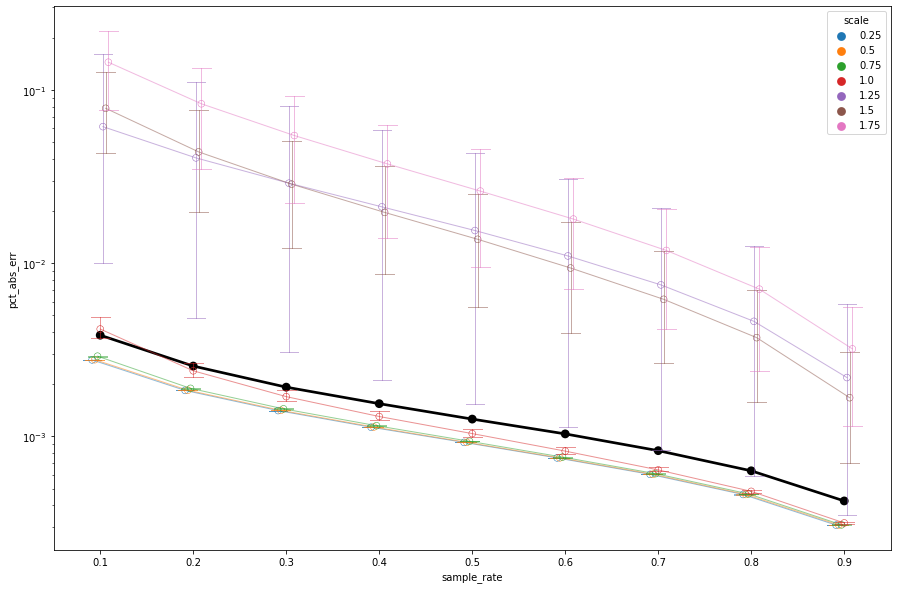

In [26]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.pointplot(
    data=exp_df[(exp_df['sample_rate'] < 1) & (exp_df['num_alts'] == 200000)],
    x='sample_rate', y='pct_abs_err', ax=ax, hue='scale', capsize=.2, dodge=True)
_ = plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
_ = plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines

h = sns.pointplot(
    data=iter_df[iter_df['sample_rate'] < 1],
    x='sample_rate', y='pct_abs_err', ax=ax, color='k', label='CHTS', capsize=.2)

ax.set_yscale('log')

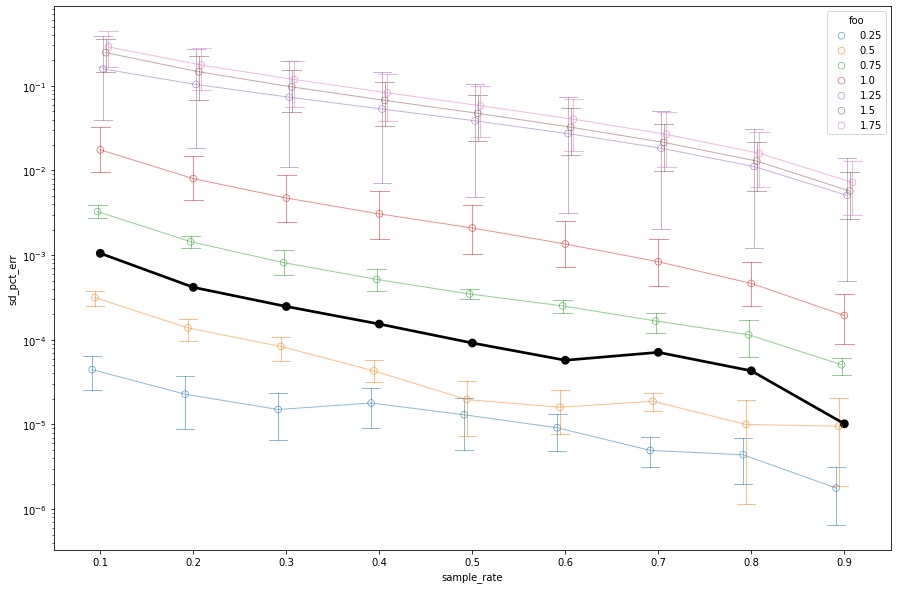

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.pointplot(
    data=exp_df[(exp_df['sample_rate'] < 1) & (exp_df['num_alts'] == 200000)].abs(),
    x='sample_rate', y='sd_pct_err', ax=ax, hue='scale', capsize=.2, dodge=True)
_ = plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
_ = plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines

h = sns.pointplot(
    data=iter_df[iter_df['sample_rate'] < 1].abs(),
    x='sample_rate', y='sd_pct_err', ax=ax, color='k', label='CHTS', capsize=.2)
ax.legend(title='foo')
ax.set_yscale('log')

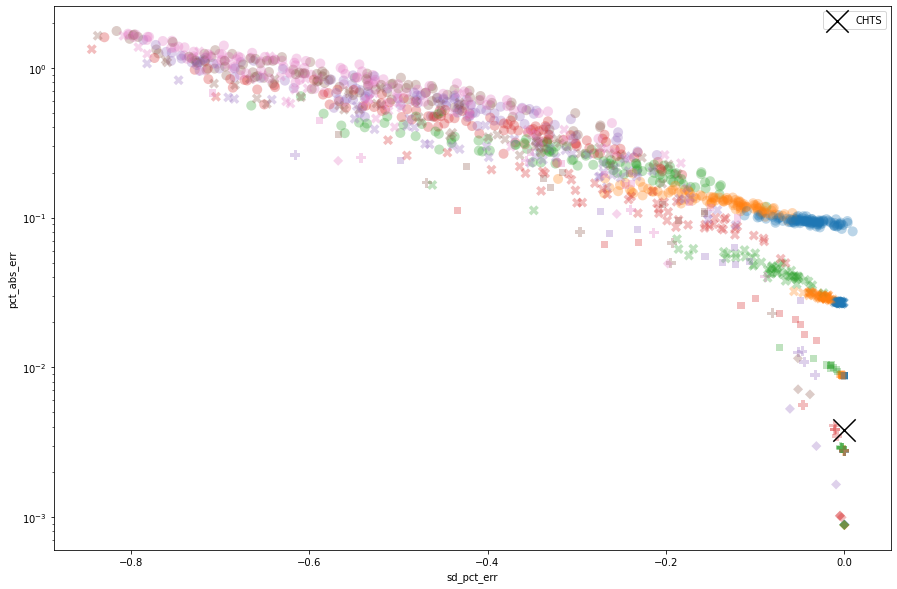

In [61]:
fig, ax = plt.subplots(figsize=(15,10))
exp_df['scale'] = exp_df['scale'].astype(str)
exp_df['num_alts'] = exp_df['num_alts'].astype(str)
g = sns.scatterplot(
    data=exp_df[(exp_df['sample_rate'] < 1) & (exp_df['sample_rate'] == 0.1)],
    x='sd_pct_err', y='pct_abs_err', ax=ax, hue='scale', s=100, alpha=0.3, edgecolor='none', style='num_alts', legend=False)
# _ = plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
# _ = plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines
ax.scatter(
    iter_df.loc[iter_df['sample_rate'] == 0.1, 'sd_pct_err'],
    iter_df.loc[iter_df['sample_rate'] == 0.1, 'pct_abs_err'], label='CHTS', s=500, c='k', marker='x')
# h = sns.boxplot(
#     data=iter_df[iter_df['sample_rate'] < 1].abs(),
#     x='sample_rate', y='pct_abs_err', ax=ax, color='k', label='CHTS', capsize=.2)
# ax.legend(title='foo')
# ax.set_yscale('log')
ax.legend()
ax.set_yscale('log')

In [67]:
alts_df.shape[0]

106910

In [69]:
alts_df.dtypes

sample_rate      float64
total_abs_err    float64
pct_abs_err      float64
rmse             float64
mape             float64
sd_pct_err       float64
num_alts           int64
num_choosers       int64
scale            float64
run_id             int64
dtype: object

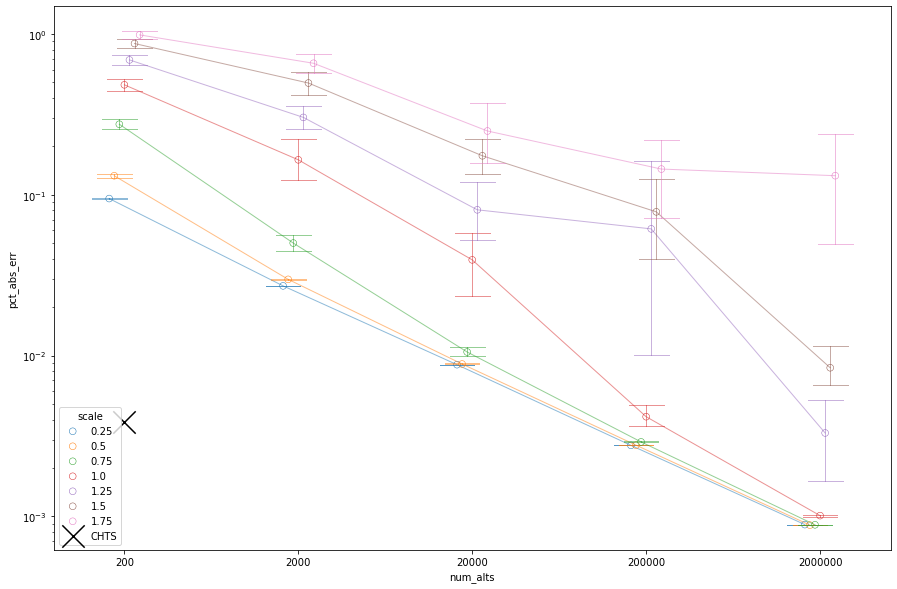

In [75]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.pointplot(
    data=exp_df[(exp_df['sample_rate'] == 0.1)].abs(),
    y='pct_abs_err', x='num_alts', ax=ax, hue='scale', capsize=.2, dodge=True)
_ = plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
_ = plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines
ax.scatter(
    '106910',
    iter_df.loc[iter_df['sample_rate'] == 0.1, 'pct_abs_err'], label='CHTS', s=500, c='k', marker='x')
# h = sns.pointplot(
#     data=iter_df[iter_df['sample_rate'] < 1].abs(),
#     x='sample_rate', y='sd_pct_err', ax=ax, color='k', label='CHTS', capsize=.2)
ax.legend(title='scale')
ax.set_yscale('log')

In [100]:
df

,sample_rate,total_abs_err,pct_abs_err,rmse,mape,sd_pct_err,num_alts,num_choosers,scale,run_id
0,0.1,67.836270,0.090448,0.508186,0.095070,0.030036,200,750,0.25,2
1,0.2,45.248688,0.060332,0.321269,0.060897,0.014957,200,750,0.25,2
2,0.3,33.477303,0.044636,0.253437,0.043553,0.014258,200,750,0.25,2
3,0.4,28.708364,0.038278,0.220212,0.035119,0.016897,200,750,0.25,2
4,0.5,24.039680,0.032053,0.185958,0.030261,0.010380,200,750,0.25,2
...,...,...,...,...,...,...,...,...,...,...
11755,0.6,79016.914062,0.010536,15.106456,inf,0.026798,2000000,7500000,1.75,169
11756,0.7,51343.261719,0.006846,9.851090,0.004036,0.017451,2000000,7500000,1.75,169
11757,0.8,30319.087891,0.004043,5.818004,0.002385,0.010313,2000000,7500000,1.75,169
11758,0.9,13431.427734,0.001791,2.579668,0.001062,0.004579,2000000,7500000,1.75,169


Text(0.5, 1.0, '10% Sample Rate')

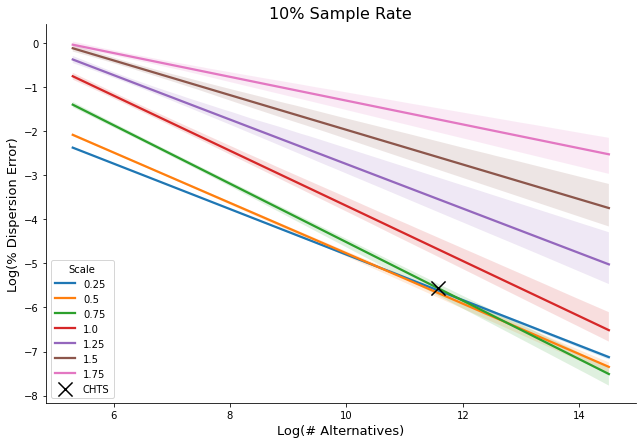

In [126]:
# fig, ax = plt.subplots(figsize=(15,10))
df = exp_df.copy().abs()
df['scale'] = df['scale'].astype(str)
df['log_pct_abs_err'] = np.log(df['pct_abs_err'].values)
df['log_num_alts'] = np.log(df['num_alts'].values)
g = sns.lmplot(
    data=df[(df['sample_rate'] == 0.1)],
    y='log_pct_abs_err', x='log_num_alts', hue='scale', scatter=False, height=6, aspect=1.5, legend=False)
ax = g.ax
# _ = plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
# _ = plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines
ax.scatter(
    np.log(106910),
    np.log(iter_df.loc[iter_df['sample_rate'] == 0.1, 'pct_abs_err'].values),
    label='CHTS', s=200, c='k', marker='x', zorder=10)
ax.legend(title='Scale')
_ = ax.set_xlabel("Log(# Alternatives)", fontsize=13)
_ = ax.set_ylabel("Log(% Dispersion Error)", fontsize=13)
ax.set_title("10% Sample Rate", fontsize=16)

Text(0.5, 1.0, '50% Sample Rate')

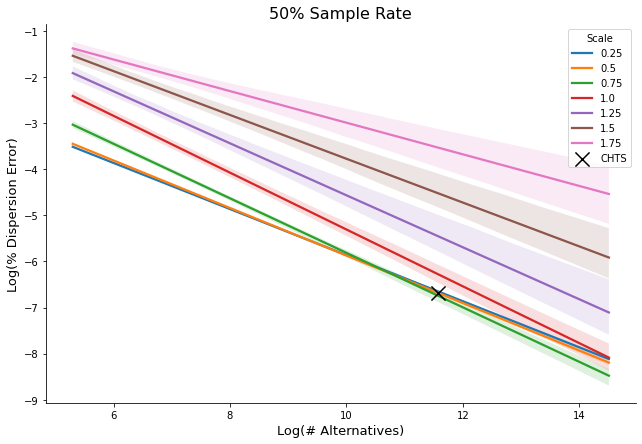

In [129]:
# fig, ax = plt.subplots(figsize=(15,10))
df = exp_df.copy().abs()
df['scale'] = df['scale'].astype(str)
df['log_pct_abs_err'] = np.log(df['pct_abs_err'].values)
df['log_num_alts'] = np.log(df['num_alts'].values)
g = sns.lmplot(
    data=df[(df['sample_rate'] == 0.5)],
    y='log_pct_abs_err', x='log_num_alts', hue='scale', scatter=False, height=6, aspect=1.5, legend=False)
ax = g.ax
# _ = plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
# _ = plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines
ax.scatter(
    np.log(106910),
    np.log(iter_df.loc[iter_df['sample_rate'] == 0.5, 'pct_abs_err'].values),
    label='CHTS', s=200, c='k', marker='x', zorder=10)
ax.legend(title='Scale')
_ = ax.set_xlabel("Log(# Alternatives)", fontsize=13)
_ = ax.set_ylabel("Log(% Dispersion Error)", fontsize=13)
ax.set_title("50% Sample Rate", fontsize=16)